# Pairs Trading Notebook - Will Friend

## Introduction

This notebook looks to implement a pairs trading strategy involving cryptocurrency historical data downloaded from Binance using the Binance python API. We download nearly four years of data from January of 2021 through the end of Q3 2024, and define the formation period as Q1 2021 - Q3 2022, and our trading period as Q4 2022 - Q3 2024.

### Pairs Trading

Pairs trading is a subset of statistical arbitrage, where one uses statistical tools to identify co-moving asset (assets that, while may be on different orders of trading price, or volume, tend to move with each other). When a pair has been identified, one looks for deviations from there mean spread (or a break in the co-movement). 

Say we have two assets that are deemed highly correlated and co-move, asset A and B, where A is priced higher than B. One day, we see that asset A has jumped (lowered) in price, while asset B has lowered (increased) in price. This breaks the co-movement, as the spread between the two stocks is now x amount greater (less) than the mean spread seem when co-moving. 

This increase (decrease) in the spread relative to the mean is the signal pairs trading seeks to capitalize on. The strategy relies around the correlation of the stocks and the assumption that any deviation from there co-movement will always revert back to the mean (ie any increases or decreases from the mean will always eventually return to the stable state). A simple strategy is to track the movement of the stocks and their spread, and to enter a position when the spread deviates from the mean:
- if asset A increases (decreases) and asset B decreases (increases) at time t, we would enter a short (long) position with asset A and a long (short) position for assset B.
- We would exit our positions once the assets have returned to their steady state in their spread (or clos enough using a threshold defined by the trader).

## Python Implementation

### Packages

We being by importing the necessary python packages to implement the data. We use the Binance API to download relevant historical cryptocurrency k-line data, and use pandas to store the data in readable DataFrames. We import numpy and varying libraries from the statsmodels package to help us carry out the statistical analysis, pandas as the backbone of working with the data, and matplotlib and seaborn to help us visualize the data and analysis:

In [1]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pdb
import warnings 
warnings.filterwarnings('ignore')

client = bnb_client(tld='US')

_dict = client.get_exchange_info()['symbols']

### Creating our Universe

Next using the binance client we create a list of available coin tickers, and filter for those that
1) Are not coins tracking currency
2) Are stable coins under the "Tethered" price index (USDT)

In [2]:
univ = []
for i in _dict:
    if 'USDT' in i['symbol'] and 'USD' not in i['symbol'][0:3]:
        univ.append(i['symbol'])
        
print(f"There are {len(univ)} coins found.")

There are 177 coins found.


From above we see that 177 coins were found to date. Next we will download the historical data for the coins found above. Below we define a function to download the historical data of a specific coin at a defined frequency, and store the data in a pandas DataFrame:

In [3]:
def get_binance_px(symbol,freq,start_ts = '2021-01-01', end_ts = '2024-09-30'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 

# univ = ['BTCUSDT', 'ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

freq = '1d'
px = {}
vol = {}
for x in univ:
    data = get_binance_px(x,freq)
    # pdb.set_trace()
    px[x] = data.set_index('open_time')['close']
    vol[x] = data.set_index('open_time')['volume']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()
vol = pd.DataFrame(vol).astype(float)
vol = vol.reindex(pd.date_range(vol.index[0],vol.index[-1],freq=freq))

We downloaded data at a frequency of one day, and saved the closing price and the volume for each coin in their own data frame. We then calculated the return data based on the closing price DataFrame.

### Data Processing

For formation of our strategy, we will filter our coins so that any coins that either entered or exited the market during our period of interest are dropped from our dataset. For Backtesting we will relax this restriction:

In [4]:
px_adj = px.dropna(axis=1)
vol_adj = vol.loc[px_adj.index]
px_adj

,BTCUSDT,ETHUSDT,BCHUSDT,LTCUSDT,BNBUSDT,ADAUSDT,BATUSDT,ETCUSDT,XLMUSDT,ZRXUSDT,...,MKRUSDT,ONEUSDT,BANDUSDT,STORJUSDT,UNIUSDT,SOLUSDT,EGLDUSDT,PAXGUSDT,OXTUSDT,ZENUSDT
2021-01-01,29305.29,728.52,341.28,126.19,37.6696,0.17488,0.2043,5.6515,0.13170,0.3738,...,581.14,0.00425,5.4899,0.2945,4.7488,1.8455,26.049,1948.03,0.2300,11.813
2021-01-02,32162.01,774.56,353.76,136.99,38.2207,0.17726,0.2037,5.7741,0.12758,0.3613,...,608.64,0.00428,6.0015,0.2922,4.8595,1.7955,25.935,1984.98,0.2343,11.674
2021-01-03,33031.74,978.14,422.97,160.86,41.1282,0.20624,0.2172,6.5539,0.13634,0.3907,...,678.57,0.00491,6.7898,0.3154,5.5152,2.1682,27.167,1954.21,0.2295,13.328
2021-01-04,32005.27,1042.10,404.44,155.55,41.0884,0.22533,0.2185,7.0553,0.16407,0.3923,...,685.71,0.00491,6.7136,0.2982,5.4310,2.4924,30.639,2005.48,0.2320,13.292
2021-01-05,33946.09,1100.22,418.34,158.13,41.8000,0.25913,0.2312,7.2447,0.19408,0.4450,...,764.03,0.00499,7.4138,0.3169,6.2500,2.1561,33.889,2029.10,0.2585,14.241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,65051.65,2632.69,349.80,68.51,596.5000,0.40080,0.1947,20.2000,0.09800,0.3529,...,1615.00,0.01440,1.2930,0.4384,7.2620,155.2300,29.550,2662.00,0.0786,8.520
2024-09-27,65785.70,2695.00,359.40,71.20,607.1000,0.40140,0.1942,20.8400,0.09860,0.3694,...,1716.00,0.01507,1.3450,0.4410,7.6160,157.7700,30.260,2645.00,0.0785,8.800
2024-09-28,65908.11,2675.60,352.60,69.96,599.9000,0.40020,0.1923,20.5000,0.09960,0.3553,...,1683.00,0.01444,1.3040,0.4250,7.5690,156.7100,29.070,2638.00,0.0791,8.590
2024-09-29,65670.63,2657.77,351.40,69.38,595.7000,0.39640,0.1901,20.2400,0.10160,0.3623,...,1651.00,0.01460,1.3100,0.4334,7.4200,158.3900,29.420,2662.00,0.0788,8.480


After applying our filtering criteria we are left with 29 coins to conduct our formation analysis on.

### Finding Co-moving Pairs

We will go through two different statistical descriptions of finding "co-moving pairs" of assets. Two do this, we must first define our formation period:

In [5]:
form_px = px_adj.loc["2021-01-01":"2022-09-30"]

#### Correlation

The key to pairs trading is finding statistically co-moving pairs. **Correlation** is often used in pairs trading strategies to determine in two assets are comoving. While two sets of data can be significantly correlated, though, it does not mean that they are necessarily maintaining a mean reverting spread. For example, say we have two datasets in the domain [0,10], where one is $y=x$ and the other is $y=x^2$:

Correlation: 0.9676443927131407


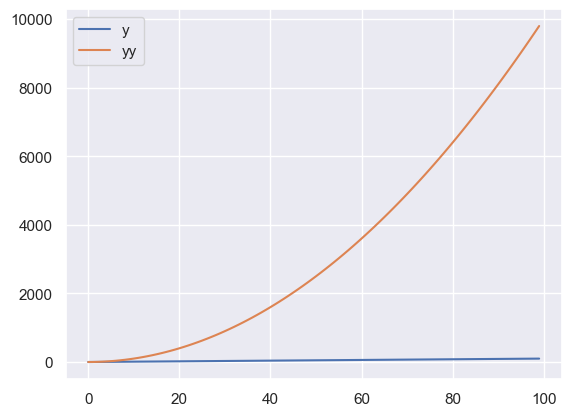

In [6]:
x = np.arange(0,100)
y = x
yy = x**2

df = {}
df['y'] = pd.Series(y)
df['yy'] = pd.Series(yy)

df = pd.DataFrame(df)

df.plot()

print(f"Correlation: {df['y'].corr(df['yy'])}")

From above, we can see that even though there is a high correlation values between these two sets of data, they are diverging from each other.

#### Cointegration

Rather than test for correlation between two assets, we could look at **cointegration**. Cointegration, while similar in theory to correlation, is specifically used for time series data. We define cointegration between two series as follows:
- If two time series *X* and *Y* are each integrated of order *d*, they are said to be cointegrated if there exists coeficients *a, b* such that $aX+bY$ is integrated of order less than *d*.

Let us test the cointegration of the two series above:

In [7]:
score, p_value, _ = coint(df['y'], df['yy'])

print(f"Cointegration test p-value: {p_value}")

Cointegration test p-value: 0.981710178136942


We can see that although the datasets are correlated, the p-value of nearly 1 cannot allow us to reject the null-hypothesis that the two datasets are cointegrated.

#### Correlation vs. Cointegration to find trading pairs

Let us explore the two methods outlined above to see how they differ in practice.

For correlation, we will simply iterate over the columns of our formation period price history, and use the pandas dataframe built in *corr* method to measure their correlation value. If the pair have a correlation value over 0.875, they are deemed correlated enough to be co-moving, and added to a list of tradeable pairs.

For cointegration, we will use the Augmented Dickey-Fuller (ADF) Cointegration Test from the statsmodel package.

We define a correlated pair when:
- The p-value of the test is below 0.05, allowing us to reject the null-hypothesis that the two time series are not cointegrated


In [8]:
n = form_px.shape[1]
p_values = np.empty((n,n))
pairs_corr = []
pairs_coint = []

count = 0

for i in range(n):
    for j in range(i+1,n):

        tmp1 = np.log(form_px.iloc[:,i])
        tmp2 = np.log(form_px.iloc[:,j])
        
        corr = tmp1.corr(tmp2)
                
        if corr >= 0.875:
            pairs_corr.append((tmp1.name, tmp2.name))

        tmp1 = sm.add_constant(tmp1)

        model = sm.OLS(tmp2, tmp1)
        results = model.fit()

        alpha = results.params.values[0]
        beta = results.params.values[1]

        residual = tmp2 - (alpha + beta * tmp1[tmp1.columns[1]])
        
        test_results = adfuller(residual, maxlag=1)
        
        if test_results[1] <= 0.05:
            
            pairs_coint.append((tmp1.columns[1], tmp2.name))

Lets now compare the two lists of pairs generated by each method:

In [9]:
print(f"Number of pairs found through correlation : {len(pairs_corr)}")
print(f"Number of pairs found through cointegration : {len(pairs_coint)}")

overlap = [p in pairs_coint for p in pairs_corr]

print(f"Number of overlapping pairs between correlation and cointegration : {np.sum(overlap)}")

Number of pairs found through correlation : 93
Number of pairs found through cointegration : 161
Number of overlapping pairs between correlation and cointegration : 77


We can see that cointegration predicts nearly two times more co-moving pairs than correlation does. The two methods agree on 77 out of 93 possible pairs to overlap with, meaning there is some consistency between the two methods. When we go to Backtest our strategy, we will see if the number of pairs creates a significant difference between how the two implementations perform.

### Defining Trading Signals

Next we will seek to define our trading signals. Specifically, we will look to identify when we will long (short) asset A and short (long) asset B in each of the pairs found in the section above. We want to identify our signal independent of market movement, defined hereout as $\beta$. In other words, we want to find the alpha of our spread between the two spreads, and define our signals based on this alpha. 

We define alpha as follows:
- We have two co-moving time series. Assuming some linear relationship between the two, we can regress asset A against asset B
    - $A = \alpha + \beta*B + \epsilon$, where $\alpha$ is the regression constant, $\beta$ is the regression slope, and $\epsilon$ is the residual of the regression
- Typically we say that the "purified" signal is the component of $\alpha + \epsilon$. In our analysis, however, we will only be considering the residual component $\epsilon$. 
- In order to understand the change in alpha, we will then transform it using its z-score in order to define signals based off of movements in stadard deviation space

We will walk through this with a single pair first, and then define a function to do this for all of our pairs. We will use one of the overlapping pairs between the correlation and cointegration methods to carry out the example.

In [10]:
pair = pairs_corr[1]
print(pair)

('BTCUSDT', 'LTCUSDT')


We will be looking at the pair Bitcoin and Litecoin. Let us carry out the steps we defined above (we will be using the formation period for this analysis to remain unbiased going into creating our backtest):

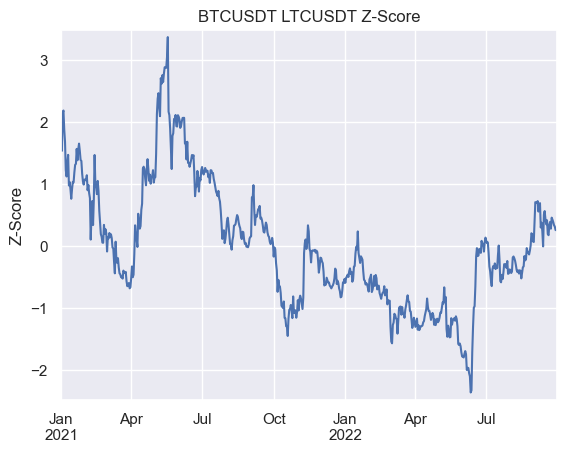

In [11]:
X = np.log(form_px[pair[0]])
X = sm.add_constant(X)
Y = np.log(form_px[pair[1]])

results = sm.OLS(Y,X).fit()

alpha = results.params[0]
beta = results.params[1]

residual = Y - (beta*X.iloc[:,1]) - alpha

z_score = (residual - residual.mean()) / residual.std()

_ = z_score.plot(title=pair[0] + " " + pair[1] + " Z-Score")
_ = plt.ylabel("Z-Score")
plt.margins(0.02)

Above we see a plot of the z-score for the pair. The y axis is deviation of the residual from the mean in terms standard deviations, since we define the z-score as $z=\frac{x-\mu}{\sigma}$, where $\mu$ is the mean of the dataset and $\sigma$ is the standard deviation of the dataset. 

We don't want to trade every time the spread moves away from 0 on the z_score, as this would be cumbersome and result in a great deal of transaction costs and unnecessary trades. We want to select larger jumps in spread that we can capitalize on for large returns while also making the amount of trades reasonable. Lets look at points where the spread jumps more than a standard deviation away from the mean: 

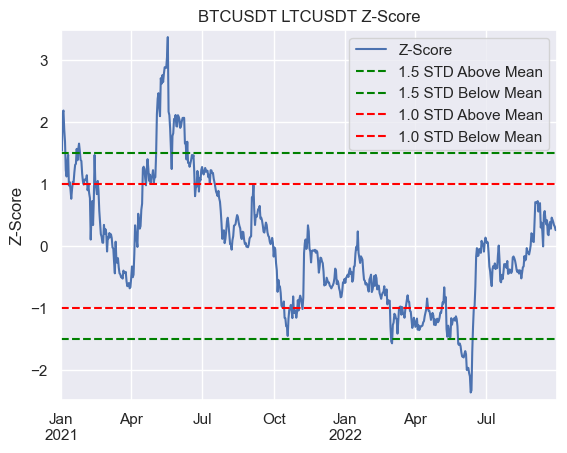

In [12]:
_ = z_score.plot(title=pair[0] + " " + pair[1] + " Z-Score", label="Z-Score")
_ = plt.axhline(1.5, color='green', linestyle='--', label="1.5 STD Above Mean")
_ = plt.axhline(-1.5, color='green', linestyle='--', label="1.5 STD Below Mean")
_ = plt.axhline(1.0, color='red', linestyle='--', label="1.0 STD Above Mean")
_ = plt.axhline(-1.0, color='red', linestyle='--', label="1.0 STD Below Mean")
_ = plt.legend()
_ = plt.ylabel("Z-Score")
plt.margins(0.02)

From the plot above we can see that the z-score reaches values over 1.5 and under -1.5 several times over the two year period. This is a large enough movement for us to enter in on a position, however, for the sake of ensure sustained movement we will make our enter signal when there is 1.5 STD movement from the mean spread (green above), and we will exit the position at 1.0 STD away from the mean (red above) (we will look to optimize this after full implementation).

## Building Strategy

Now that we have some idea of how to construct the signals we care about, let us now begin to construct the code that will implement this strategy in a more automated way.

Above we used the z-score to define our signal. To account for market movement, we will define our z-score by using a rolling average and standard deviation:

$$ 
z = \frac{\epsilon_{t} - \bar{\epsilon}_{t-window}}{\sigma_{t-window}}
$$

We will define our window to be 14 days. We will start with our entry signal being 1.5 STD away from the mean, and our exit signal being when it reverts back to 1.0 STD from the mean.

To correct for possible decorrelation of pairs as the market evolves during the trading period, we will also implement a rebalance period $T_r$, where every $T_r$ days we will exit our positions held, and will find new correlated pairs from the previous $T_r$ days. We define our rebalance period to be every 180 days.

### Metrics of Strategy

Before we backtest and assess the performance of our strategy, we need to consider what metrics we will use for evaluating performance, and incorporating transaction cost into our backtest in order to accurately model the performance. 

First we will talk about the transaction cost. On average, cryptocurrencies have commissions of 7bps, to first order. We will then also assume an additional 13bps to cover slippage (while this quantity is unknown and dependent on the trader and the amount of trading volume). This leaves us with a total transaction cost of 20bps for market-orders.

We will want to track how much our portfolio is trading over time. To do this we will look at the **turnover/holding period**. We define turnover as:

$$
Turnover_{t}=\sum_{i=1}^{n}abs(w_{i,t}-w_{i,t-1}),
$$

where $w_{i,t}$ is the portfolio weight of asset *i* at time *t*. We define the holding period as

$$
Holding\ Period = \frac{2}{Average\ Turnover}.
$$

Finally for evaluating the performance of the portfolio, we will look at 1) the annualized Sharpe Ratio and 2) the cummulative returns. As a reminder, we define the Sharpe Ratio as the average returns over the trading period divided by the volatility of the trading period. To annualize, we simple multiple the Sharpe Ratio by the square-root of the number of days in a year (365).

### Code implementation

Below are two python classes used to carry out the backtesting and performance calculations of our strategy. The **Utils** class contains methods for determining performance of the strategy, as well as methods for weighting our strategy with another (if we choose to combine this pairs trading strategy with another statistical arbitrage strategy). The **PairsBacktest** class defines methods to find co-moving pairs, create our trading signals, create a portfolio based on the generated signal, and how to trade on that portfolio given our data and rebalance criteria.

In [13]:
import binance
import numpy as np
import os
import pandas as pd


class Utils:
    
    def __init__(self, save_portf: str=os.getcwd()) -> None:
        
        self.save_portf = save_portf
        
    def get_binance_px(self, client: binance.client.Client, symbol: str, freq: str, start_ts: str='2021-01-01', end_ts: str='2023-12-31') -> pd.DataFrame:
        
        from datetime import datetime
        
        data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
        columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
        'num_trades','taker_base_volume','taker_quote_volume','ignore']

        data = pd.DataFrame(data,columns = columns)

        # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
        data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
        data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
        
        return data 
        
    def turnover(self, portf: pd.DataFrame) -> pd.Series:

        to = (portf.fillna(0) - portf.shift().fillna(0)).abs().sum(axis=1)

        return to

    def ann_sharpe(self, ret: pd.DataFrame) -> float:
        
        avg_ret = ret.mean() * 365
        vol_ret = ret.std() * np.sqrt(365)
        sr = avg_ret / vol_ret

        return sr
    
    def optimal_weights(self, sigma: pd.DataFrame, mu: float) -> pd.Series:
        
        try:
            wgt = np.linalg.inv(sigma) @ mu 
            wgt = wgt / np.abs(wgt).sum()  
            
        except np.linalg.LinAlgError as err:
            sigma_value = sigma.iloc[0,0]
            sigma = np.diag(np.full(sigma.shape[0],sigma_value))
            wgt = np.linalg.inv(sigma) @ mu 
            wgt = wgt / np.abs(wgt).sum()

        return wgt

    def eqvol_weights(self, sigma: pd.DataFrame) -> pd.Series:
        
        wgt = 1/np.sqrt(np.diag(sigma))
        wgt = wgt / np.abs(wgt).sum()
        
        return wgt

    def sr_weights(self, sigma: pd.DataFrame, mu: float) -> pd.Series:
        
        wgt = mu / np.diag(sigma) 
        wgt = wgt / np.abs(wgt).sum()
        
        return wgt
    
    def save_portfolio(self, portf: pd.DataFrame) -> None:
        
        portf.to_pickle(self.save_portf)
        
        print(f"Dataframe saved to {self.save_porft}")
        
    def drawdown(self, returns):
        # Calculate cumulative returns
        cumulative = (1 + returns).cumprod()

        # Calculate the running maximum
        running_max = cumulative.cummax()

        # Calculate drawdown
        drawdown = (cumulative - running_max) / running_max

        return drawdown
    
    def duration(self, px):

        peak = px.expanding(min_periods=1).max()
        res = pd.DataFrame(index=px.index,columns=px.columns)

        for col in px.columns:
            for dt in px.index:

                if px.loc[dt,col] >= peak.loc[dt,col]:
                    res.loc[dt,col] = 0

                else:    
                    res.loc[dt,col] = res.loc[:dt,col].iloc[-2] + 1

        return res

In [14]:
class PairsBacktest:
    
    def __init__(self, window: int=60, entry_signal: float=1, exit_signal: float=0.5) -> None:
        
        self.window = window
        self.entry_signal = entry_signal
        self.exit_signal = exit_signal
        
    def get_pairs(self, px: pd.DataFrame, coint: bool=False) -> list:
        
        if coint:
            
            n = px.shape[1]
            p_values = np.empty((n,n))
            pairs = []

            count = 0

            for i in range(n):
                for j in range(i+1,n):

                    tmp1 = np.log(px.iloc[:,i])
                    tmp2 = np.log(px.iloc[:,j])
                    
                    if np.sum(tmp1.isna()) > 0 or np.sum(tmp2.isna()) > 0:
                        continue

                    tmp1 = sm.add_constant(tmp1)
                    
                    model = sm.OLS(tmp2, tmp1)
                    results = model.fit()

                    alpha = results.params.values[0]
                    beta = results.params.values[1]
                    
                    residual = tmp2 - (alpha + beta * tmp1[tmp1.columns[1]])

                    test_results = adfuller(residual, maxlag=1)

                    if test_results[1] <= 0.05:

                        pairs.append((tmp1.columns[1], tmp2.name))
                        
            return pairs
            
        
        else:
        
            n = px.shape[1]
            pairs = []

            for i in range(n):
                for j in range(i+1,n):

                    tmp1 = np.log(px.iloc[:,i])
                    tmp2 = np.log(px.iloc[:,j])

                    corr = tmp1.corr(tmp2)

                    if corr >= 0.875:
                        pairs.append((tmp1.name, tmp2.name))

            return pairs
    
    def get_signal(self, px: pd.DataFrame, pairs: list) -> pd.DataFrame:
        
        signals = {}
        
        for pair in pairs:

            X = np.log(px[pair[0]]).fillna(0)
            Y = np.log(px[pair[1]]).fillna(0)
          
            X = sm.add_constant(X)

            if len(X) < self.window:
                
                reg = RollingOLS(Y,X,window=(len(X)+2),expanding=True).fit()

                alpha = reg.params['const'].fillna(method='bfill')
                beta = reg.params[pair[0]].fillna(method='bfill')

                residual = Y - (X[pair[0]]*beta) - alpha

                z_score = (residual - residual.rolling(window=(len(X)+2),min_periods=1).mean()) / residual.rolling(window=(len(X)+2),min_periods=1).std()

                signals[(pair,"z-score")] = z_score
                signals[(pair,"beta")] = beta
            
            else:
        
                reg = RollingOLS(Y,X,window=self.window,expanding=True).fit()

                alpha = reg.params['const'].fillna(method='bfill')
                beta = reg.params[pair[0]].fillna(method='bfill')

                residual = Y - (X[pair[0]]*beta) - alpha

                z_score = (residual - residual.rolling(window=self.window,min_periods=1).mean()) / residual.rolling(window=self.window,min_periods=1).std()

                signals[(pair,"z-score")] = z_score
                signals[(pair,"beta")] = beta
            
        signals = pd.DataFrame(signals)
        
        return signals
    
    def get_portfolio(self, px: pd.DataFrame, signals: pd.DataFrame, pairs: list) -> pd.DataFrame:
        
        portf = pd.DataFrame(columns=px.columns, index=px.index)
        
        for pair in pairs:
            
            z_score = signals[(pair,"z-score")]
            beta = signals[(pair,"beta")]
            
            portf.loc[(z_score.fillna(0) > self.entry_signal)&(z_score.shift().fillna(0) < self.entry_signal),pair[0]] = 1
            portf.loc[(z_score.fillna(0) < self.exit_signal)&(z_score.shift().fillna(0) > self.exit_signal),pair[0]] = 0
        
            portf.loc[(z_score.fillna(0) > self.entry_signal)&(z_score.shift().fillna(0) < self.entry_signal),pair[1]] = -1
            portf.loc[(z_score.fillna(0) < self.exit_signal)&(z_score.shift().fillna(0) > self.exit_signal),pair[1]] = 0
            
            portf.loc[(z_score.fillna(0) < -self.entry_signal)&(z_score.shift().fillna(0) > -self.entry_signal),pair[0]] = -1
            portf.loc[(z_score.fillna(0) > -self.exit_signal)&(z_score.shift().fillna(0) < -self.exit_signal),pair[0]] = 0
            
            portf.loc[(z_score.fillna(0) < -self.entry_signal)&(z_score.shift().fillna(0) > -self.entry_signal),pair[1]] = 1
            portf.loc[(z_score.fillna(0) > -self.exit_signal)&(z_score.shift().fillna(0) < -self.exit_signal),pair[1]] = 0
            
        portf = portf.ffill()
        portf = portf.divide(portf.abs().sum(axis=1),axis=0).fillna(0)
        
        return portf
    
    def trade_pairs(self, px: pd.DataFrame, rebalance_dates: list, rebalance_val: int, coint: bool=False) -> (pd.Series, pd.DataFrame):
        
        total_pairs = []
        
        utils = Utils()
        
        net_ret = pd.Series(index=px.index,name="Pairs Trading")
        num_pairs = pd.Series(index=px.index,name="Number of Pairs")
        # pdb.set_trace()
        net_ret = net_ret.loc[rebalance_dates[1]:]
        
        for ii in range(1,len(rebalance_dates)):
            
            if ii == len(rebalance_dates)-1:
                form_pairs = px.loc[rebalance_dates[ii-1]:rebalance_dates[ii]-pd.DateOffset(1),:]
                trade_pairs = px.loc[rebalance_dates[ii]:,:]
            else:
                form_pairs = px.loc[rebalance_dates[ii-1]:rebalance_dates[ii]-pd.DateOffset(1),:]
                trade_pairs = px.loc[rebalance_dates[ii]:rebalance_dates[ii+1]-pd.DateOffset(1),:]
            
            pairs = self.get_pairs(form_pairs, coint)
            
            for pair in pairs:
                if pair not in total_pairs:
                    total_pairs.append(pair)
            
            signals = self.get_signal(px=trade_pairs, pairs=pairs)
            
            portf = self.get_portfolio(px=trade_pairs,signals=signals,pairs=pairs)
            
            trade_ret = trade_pairs.pct_change().fillna(0)
            strat_ret = (portf.shift() * trade_ret).sum(axis=1)
            
            to = utils.turnover(portf=portf)
            tcost_bps = 20
            # pdb.set_trace()
            net_ret.loc[trade_pairs.index] = strat_ret.subtract(to*tcost_bps*1e-4,fill_value=0)
            num_pairs.loc[trade_pairs.index] = len(pairs)
            
        net_ret = net_ret.fillna(0)
        
        evaluation = {}

        evaluation['Sharpe Ratio'] = utils.ann_sharpe(net_ret)
        evaluation['Avg. Turnover'] = to.mean()
        evaluation['Holding Period'] = 2 / to.mean()
        evaluation['Annual Returns'] = net_ret.mean() * 365
        evaluation['Annual Volatility'] = net_ret.std() * np.sqrt(365)
        evaluation['T-Cost'] = (to*tcost_bps*1e-4).mean()
        evaluation = pd.DataFrame(evaluation, index=[net_ret.name])
        
        return net_ret, evaluation, total_pairs, num_pairs


## Backtesting Strategy

We will now backtest out strategy. First we will generate the results of trading with pairs found by correlation, and then the results with pairs found by cointegration. We will then compare the two strategies as well as a buy-and-hold strategy using our proxy to the cryptocurrency market, BTC.

In [15]:
window = 14
entry_signal = 1.5
exit_signal = 1
rebalance=180
import time

start_rebalance = px.index.get_loc(form_px.index[-1]-pd.DateOffset(rebalance-1))

rebalance_dates = px.iloc[start_rebalance::rebalance].index
trade_px = px.loc[rebalance_dates[0]:,:]

btp = PairsBacktest(window=window,entry_signal=entry_signal,exit_signal=exit_signal)

print("Correlation")
t0_corr = time.time()
net_ret_corr, evaluation_corr, total_pairs_corr, num_pairs_corr = btp.trade_pairs(px=trade_px,rebalance_dates=rebalance_dates,rebalance_val=rebalance)
t1_corr = time.time()
display(evaluation_corr)
print(f"Time to backtest correlation : {t1_corr-t0_corr} seconds")
print(f"Unique pairs traded on : {len(total_pairs_corr)} \n")

print("Cointegration")
t0_coint = time.time()
net_ret_coint, evaluation_coint, total_pairs_coint, num_pairs_coint = btp.trade_pairs(px=trade_px,rebalance_dates=rebalance_dates,rebalance_val=rebalance,coint=True)
t1_coint = time.time()
display(evaluation_coint)
print(f"Time to backtest cointegration : {t1_coint-t0_coint} seconds")
print(f"Unique pairs traded on : {len(total_pairs_coint)}")

Correlation


,Sharpe Ratio,Avg. Turnover,Holding Period,Annual Returns,Annual Volatility,T-Cost
Pairs Trading,2.399494,1.284177,1.557418,0.908176,0.378486,0.002568


Time to backtest correlation : 122.09787702560425 seconds
Unique pairs traded on : 10185 

Cointegration


,Sharpe Ratio,Avg. Turnover,Holding Period,Annual Returns,Annual Volatility,T-Cost
Pairs Trading,0.771507,1.102906,1.813392,0.306694,0.397526,0.002206


Time to backtest cointegration : 162.19798517227173 seconds
Unique pairs traded on : 9679


Over our trading period, the two strategy methods generated similar number of tradeable pairs, with correlation generating only ~500 more pairs. Additionally, we see that the cointegration method took nearly 40 seconds longer to run than the correlation method. This is unsurprising given the increase in complexity of the calculation of cointegration over correlation, and worth keeping in mind as when we choose to implement a method.

From summary of performances, both strategies generated strong Sharpes. Using correlation, we generated annualized returns of 90.8% and annualized volatility of 37.8%, resulting in a Sharpe of 2.39. Using cointegration, we generated annualized returns of 30.6% and annualized volatility of 39.7%, resulting in a Sharpe of 0.77. This performance is signifiacntly weaker. 

Next we will investigate the strategies compared after their rebalance bperiods by plotting the number of pairs traded on in each rebalance period over the entire backtest period. As a sanity check, we will also plot the number of coins listed in the market to ensure that there are no periods where only one coin was tradeable (ensure no holes in our time series data).

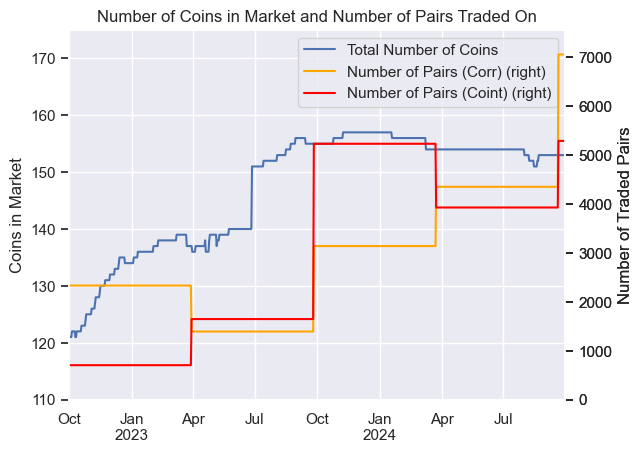

In [16]:
fig, ax = plt.subplots()

ax = (len(px.columns) - px.loc[net_ret_corr.index].isnull().sum(axis=1)).plot(label="Total Number of Coins")
ax.set_ylabel("Coins in Market")
ax.set_ylim([110,175])

ax2 = ax.twinx()
ax2 = num_pairs_corr.loc[net_ret_corr.index].plot(secondary_y=True,label="Number of Pairs (Corr)",color='orange')
ax2.set_ylabel("Number of Traded Pairs")
ax2.set_ylim([0,np.max(num_pairs_corr)+500])
plt.grid(False)

ax3 = ax.twinx()
ax3 = num_pairs_coint.loc[net_ret_corr.index].plot(secondary_y=True,label="Number of Pairs (Coint)",color='red')
ax3.set_ylabel("Number of Traded Pairs")
ax3.set_ylim([0,np.max(num_pairs_corr)+500])

lines = ax.get_lines() + ax2.get_lines() + ax3.get_lines()
ax.legend(lines, [l.get_label() for l in lines])
plt.margins(0.02)
plt.grid(False)
_ = plt.title("Number of Coins in Market and Number of Pairs Traded On")
plt.show()

From the figure above, we can see that correlation and cointegration both adjust the number of pairs trading at the rebalance date, confirming proper behavior in our code. We can see also that the number of coins inbetween rebalance dates is not the same between the two methods, showing that there is indeed a difference in how we choose to find pairs. The number of pairs traded on between the two strategies is comparable during the periods, with a noteable deviation from October 2023 - April 2024 where the cointegration strategy traded on almost 2000 more pairs. The discrepencies between pairs (not only in quantity but quality of the pair) most likely is the largest contributer to the strategy performance difference.

## Comparing to Buy-And-Hold Strategy with BTC

Lets now compare the two strategies to a simple buy-and-hold strategy with BTC. 

### Drawdown 

We will first look at the drawdown of the three strategies. Drawdown is a metric that measures how far below the prior peak your portfolio is. Accompanying the drawdown are two metrics typically used to summarize your drawdown performance: the maximum drawdown and the maximum drawdown duration. The maximum drawdown tells you the furthest you deviated from a peak, while the maximum drawdown duration tells you the longest period that you spent below a previous peak. Two function are defined in the **Utils** class above to give us the drawdown and drawdown duration. From the two function outputs we can get the maximum drawdown value and the maximum drawdown duration value.

In [17]:
utils = Utils()
BH = pd.DataFrame(trade_px['BTCUSDT'].pct_change().fillna(0))
BH = BH.iloc[rebalance:,:]
port_bh = pd.Series(np.ones(len(BH)),index=BH.index,name=BH.columns[0])

In [18]:
to_BH = utils.turnover(pd.DataFrame(port_bh))
to_BH.name = port_bh.name
strat_ret_BH = (port_bh.to_frame().shift() * BH)
tcost_bps = 20 # (comissions + slip)
net_ret_BH = strat_ret_BH['BTCUSDT'].subtract(to_BH*tcost_bps*1e-4,fill_value=0)

In [19]:
ret_metrics = {}
ret_metrics['Pairs Corr'] = net_ret_corr
ret_metrics['Pairs Coint'] = net_ret_coint
ret_metrics['B&H'] = net_ret_BH
ret_metrics = pd.DataFrame(ret_metrics)

Max Pairs Trading Drawdown (Correlation): 19.06%
Max Pairs Trading Drawdown (Cointegration): 45.9%
Max Buy-and-Hold BTC Drawdown: 26.12%


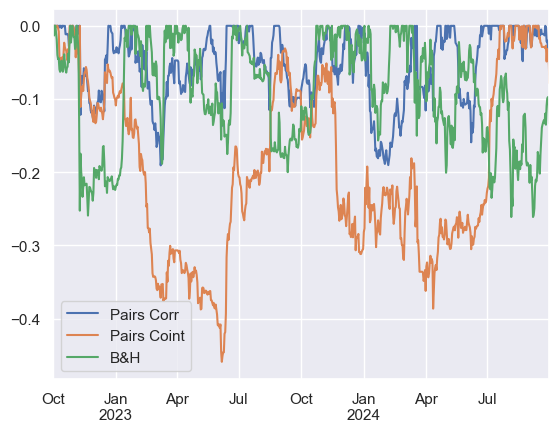

In [20]:
dd = utils.drawdown(ret_metrics)
_ = dd.plot()
print(f"Max Pairs Trading Drawdown (Correlation): {round(abs(dd['Pairs Corr'].min())*100,2)}%")
print(f"Max Pairs Trading Drawdown (Cointegration): {round(abs(dd['Pairs Coint'].min())*100,2)}%")
print(f"Max Buy-and-Hold BTC Drawdown: {round(abs(dd['B&H'].min())*100,2)}%")

Max Drawdown Duration for Pairs Trading (Correlation): 109 days
Max Drawdown Duration for Pairs Trading (Cointegration): 618 days
Max Drawdown Duration for Buy-and-Hold BTC: 201 days


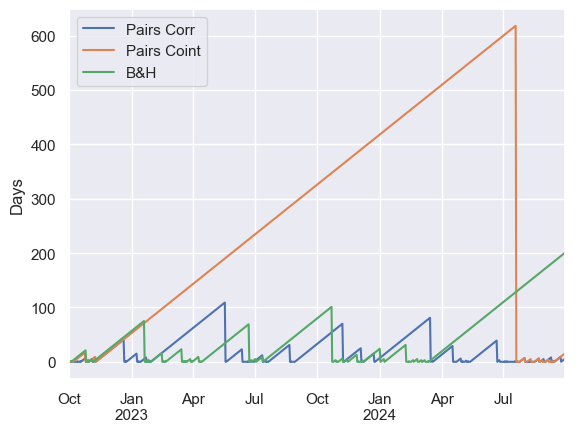

In [21]:
ddd = utils.duration(dd.fillna(0))
_ = ddd.plot()
_ = plt.ylabel("Days")
print(f"Max Drawdown Duration for Pairs Trading (Correlation): {max(ddd['Pairs Corr'])} days")
print(f"Max Drawdown Duration for Pairs Trading (Cointegration): {max(ddd['Pairs Coint'])} days")
print(f"Max Drawdown Duration for Buy-and-Hold BTC: {max(ddd['B&H'])} days")

We see that the magnitude of the drawdown over the trading period is very similar across correlation strategy and BTC. The maximum drawdown for correlated pairs is 19.06% while the maximum drawdown for BTC is 26.12%. The maximum drawdowns occur at different points in the trading period, showing the unique movement of each strategy. The maximum drawdown for the cointegration pairs is 45.9% points to the strategies possible weakness in picking effective co-moving pairs, and its overall weak performance.

Similarly, we see that the drawdown duration is comparable between correlation and BTC strategies, with many short term draw downs and few long term, with the maximum duration of drawdown being 109 days for correlation and 201 days for the buy-and-hold strategy. We can see that our correlated pairs trading implementation is able to achieve improved returns over the course of BTC continual drawdown from March 2024 to the end of the trading period (30 Sept 2024), suggesting isolation of our strategy from general market trends. Our cointegration pairs strategy suffers a max drawdown of 618 days before returning to improving performance from August 2024 - Oct 2024. That long drawdown period shed's light on the weaker annualized returns seen from the strategy.

Let's now compare the cummulative returns of our strategies to the buy-and-hold strategy with BTC:

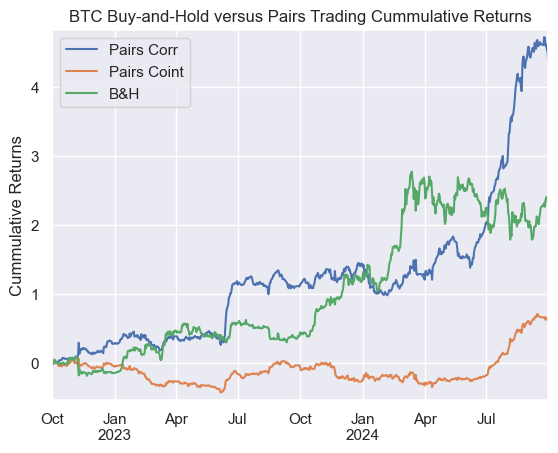

In [22]:
_ = ((1+ret_metrics).cumprod()-1).plot(title="BTC Buy-and-Hold versus Pairs Trading Cummulative Returns")
_ = plt.ylabel("Cummulative Returns")
plt.margins(0.02)

From the plot above, we can see that the correlated pairs implementation outperformed the buy-and-hold BTC strategy, achieving nearly doubled cummulative returns. We also see that our cointegration strategy does not break positive returns until the end of its max drawdown duration above.

Both curves show movement independent of BTC cummulative returns, further suggesting purification of our strategies.

Below are the annualized returns, volatility, and Sharpe Ratios are reported for each strategy.

In [23]:
combo_rets_eval = {}
combo_rets_eval['Ann. Rets'] = ret_metrics.mean() * 365
combo_rets_eval['Ann. Vol'] = ret_metrics.std() * np.sqrt(365)
combo_rets_eval['Ann. SR'] = combo_rets_eval['Ann. Rets'] / combo_rets_eval['Ann. Vol']
combo_rets_eval = pd.DataFrame(combo_rets_eval)
combo_rets_eval

,Ann. Rets,Ann. Vol,Ann. SR
Pairs Corr,0.908176,0.378486,2.399494
Pairs Coint,0.306694,0.397526,0.771507
B&H,0.710445,0.487912,1.456091


### Purifying Our Strategy

We want to confirm that our strategy is performing as independently as possible from general market movement. In other words, we want to ensure our strategy is generating alpha. To do this we will regress our strategy against BTC, the "standard index" in this case (if you were to do this with stocks traded on the S&P500, you would use SPY).

From our definition of linear regression, we will define the purified strategy as:

$$
\alpha_{t}+\epsilon_{t}=R^{Strat}_{t}-\beta*R^{BTC}_{t},
$$

where once again $\epsilon$ is the residual value from our regression, $\alpha$ is the regression constant, $\beta$ is the regression coefficient, $R^{BTC}$ is the returns of BTC, and $R^{Strat}$ is the returns of our pairs trading strategy. **NOTE**: One can see the difference between the above equation and the equation for getting out signal and finding pairs is that we define our alpha as $\alpha+\epsilon$ from the regression equation above.

Below we calculate alpha first for the correlated pairs strategy:

#### Correlated Pairs Strategy

Alpha: 0.002646354604703867
Alpha Volatility: 0.019701841068168875


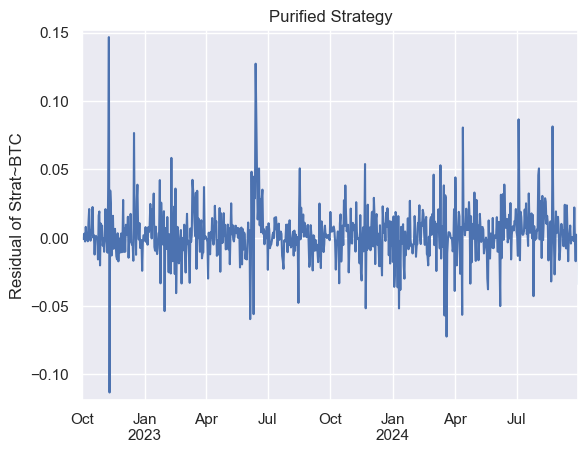

In [24]:
R_BTC = ret_metrics['B&H']
R_BTC = sm.add_constant(R_BTC)

R_Strat = ret_metrics['Pairs Corr']

model = sm.OLS(R_Strat.astype(float), R_BTC)
results = model.fit()

alpha = results.params.values[0]
beta = results.params.values[1]
resid = results.resid

alpha_contr = alpha+resid
beta_contr = - beta * R_BTC['B&H']

_ = alpha_contr.plot(title="Purified Strategy")
_ = plt.ylabel("Residual of Strat~BTC")
plt.margins(0.02)

print(f"Alpha: {alpha_contr.mean()}")
print(f"Alpha Volatility: {alpha_contr.std()}")

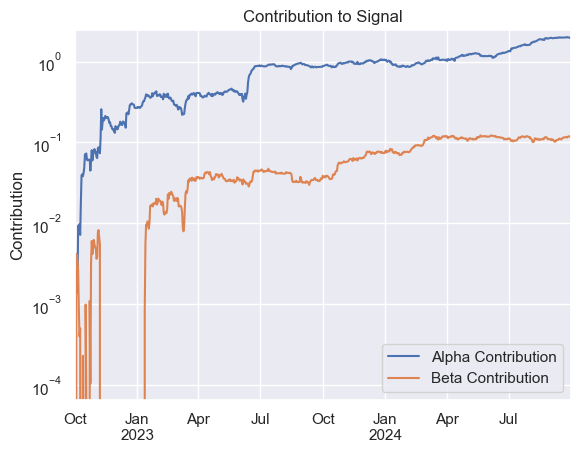

In [25]:
contribution = {}
contribution['Alpha Contribution'] = alpha_contr
contribution['Beta Contribution'] = beta_contr
contribution = pd.DataFrame(contribution)
_ = contribution.cumsum().plot(logy=True, title='Contribution to Signal')
_ = plt.ylabel("Contribution")
plt.margins(0.02)

We can see from the plots above that our alpha signal moves independently of the movement of BTC seen in the cummulative returns plot. We also can confirm that its contribution to our signal from alpha is of $10^{2}$ greater than the contribution of beta a majority of the period. Beta's contribtuion value being on the order of $10^{-2}$ shows its being truly of little contribution, helping confirm our purification. We can further investigate this by examining the correlation of beta and alpha contributions to each strategy:

In [26]:
print(f"Correlation of Alpha to Pairs Strategy: {alpha_contr.corr(R_Strat.astype(float))}")
print(f"Correlation of Alpha to BTC: {alpha_contr.corr(R_BTC['B&H'])}")
print(f"Correlation of Beta to Pairs Strategy: {beta_contr.corr(R_Strat.astype(float))}")
print(f"Correlation of Beta to BTC: {beta_contr.corr(R_BTC['B&H'])}")

Correlation of Alpha to Pairs Strategy: 0.9944957746040554
Correlation of Alpha to BTC: 1.3283049916588598e-16
Correlation of Beta to Pairs Strategy: -0.10477668774436477
Correlation of Beta to BTC: 1.0


We see extremely high correlation between our strategy and the alpha signal, while there is virtually zero correlation between alpha and BTC (showing purification). Similarly, we seethat beta's contribution to the pairs strategy is very low correlated, further showing evidence of our purification. Given the nature of the calculation, the correlation between beta and BTC is nearly 1.

Finally, we can look at the *Information Ratio* of our strategy's alpha.

The information Ratio is the Sharpe Ratio Equivalent for alpha. It acts as a measure of returns generated beyond the movement of the market. Its definition is similar to that of the Sharpe Ratio:

$$
Information\ Ratio = \frac{\bar{alpha}}{\sigma^{alpha}}
$$

where *alpha* is your purified strategy $\alpha + \epsilon$. You are dividing the mean value of your alpha by its standard deviation. The main difference versus the Sharpe Ratio is that the numerator is only the mean alpha, **not** the alpha mius the mean-alpha.

Below we calculate the information ratio:

In [27]:
ir_corr = alpha_contr.mean() / alpha_contr.std() * np.sqrt(365)
print(f"Information Ratio: {ir_corr}")

Information Ratio: 2.5661832088819194


We generate a Information Ratio of ~2.56, a very high performing value (given our high Sharpe Ratio this result makes sense). Our Information Ratio and breakdown of the purified signal show that the strategy does indeed generate a positively performing alpha! 

#### Cointegrated Pairs

Let's now perform the same analysis on teh cointegrated pairs strategy:

Alpha: 0.0010056452837595997
Alpha Volatility: 0.020693991104697378


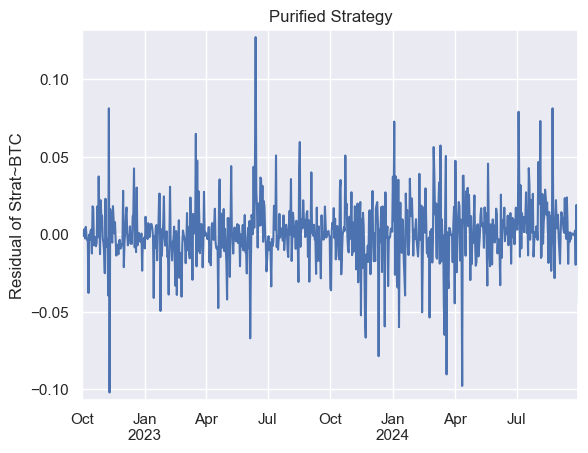

In [28]:
R_BTC = ret_metrics['B&H']
R_BTC = sm.add_constant(R_BTC)

R_Strat = ret_metrics['Pairs Coint']

model = sm.OLS(R_Strat.astype(float), R_BTC)
results = model.fit()

alpha = results.params.values[0]
beta = results.params.values[1]
resid = results.resid

alpha_contr = alpha+resid
beta_contr = - beta * R_BTC['B&H']

_ = alpha_contr.plot(title="Purified Strategy")
_ = plt.ylabel("Residual of Strat~BTC")
plt.margins(0.02)

print(f"Alpha: {alpha_contr.mean()}")
print(f"Alpha Volatility: {alpha_contr.std()}")

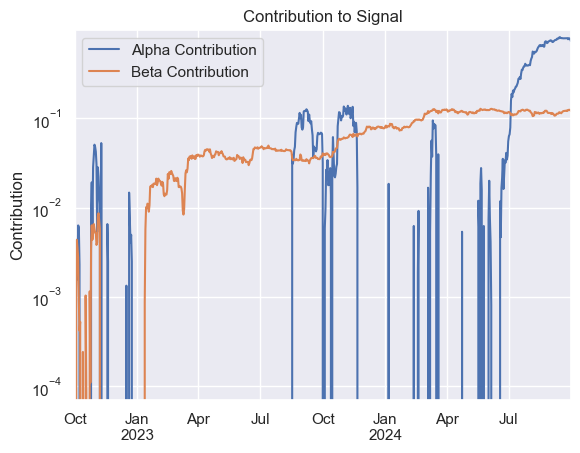

In [29]:
contribution = {}
contribution['Alpha Contribution'] = alpha_contr
contribution['Beta Contribution'] = beta_contr
contribution = pd.DataFrame(contribution)
_ = contribution.cumsum().plot(logy=True, title='Contribution to Signal')
_ = plt.ylabel("Contribution")
plt.margins(0.02)

Differing from the correlation strategy, while the alpha contribution does dominate over the trading period, we can see that it is not as large of a gap between it and beta compared to the correlation strategy. 

In [30]:
print(f"Correlation of Alpha to Pairs Strategy: {alpha_contr.corr(R_Strat.astype(float))}")
print(f"Correlation of Alpha to BTC: {alpha_contr.corr(R_BTC['B&H'])}")
print(f"Correlation of Beta to Pairs Strategy: {beta_contr.corr(R_Strat.astype(float))}")
print(f"Correlation of Beta to BTC: {beta_contr.corr(R_BTC['B&H'])}")

Correlation of Alpha to Pairs Strategy: 0.9945469486100716
Correlation of Alpha to BTC: 1.2365182218525736e-16
Correlation of Beta to Pairs Strategy: -0.10428982218028714
Correlation of Beta to BTC: 1.0


Similar to the correlated pairs strategy, we see extremely high correlation between our strategy and the alpha signal, while there is nearly zero correlation between alpha and BTC (showing purification). We also see that beta's contribution to the pairs strategy is, while low, not totally negligible at 0.1. This shows evidence of purification but to a slightly lesser degree. It is worth noting that while beta's correlation for the cointegrated pairs strategy is higher than the correlated pairs strategy, but still small enough for to still consider the strategy purified. Given the nature of the calculation, the correlation between beta and BTC is nearly 1.

Finally, we can look at the *Information Ratio* of our strategy's alpha

In [31]:
ir_coint = alpha_contr.mean() / alpha_contr.std() * np.sqrt(365)
print(f"Information Ratio: {ir_coint}")

Information Ratio: 0.9284253613587119


We generate an Information Ratio of ~0.92. The results confirm we were able to generate positive alpha, and as a sanity the cointegrated pairs strategy's information ratio can be confirmed to be close to the Sharpe ratio.

## Conclusion

In [32]:
summary_stats = {}
summary_stats['Ann. Returns'] = [combo_rets_eval.loc['Pairs Corr','Ann. Rets'],combo_rets_eval.loc['Pairs Coint','Ann. Rets']]
summary_stats['Ann. Volatility'] = [combo_rets_eval.loc['Pairs Corr','Ann. Vol'],combo_rets_eval.loc['Pairs Coint','Ann. Vol']]
summary_stats['Ann. Sharpe Ratio'] = [combo_rets_eval.loc['Pairs Corr','Ann. SR'],combo_rets_eval.loc['Pairs Coint','Ann. SR']]
summary_stats['Ann. Information Ratio'] = [ir_corr, ir_coint]

summary_stats = pd.DataFrame(summary_stats, index=['Pairs Corr', 'Pairs Coint'])
summary_stats

,Ann. Returns,Ann. Volatility,Ann. Sharpe Ratio,Ann. Information Ratio
Pairs Corr,0.908176,0.378486,2.399494,2.566183
Pairs Coint,0.306694,0.397526,0.771507,0.928425


We explored two different implementations of finding co-moving pairs of cryptocurrencies, one using simple correlation between two assets, and the other looking at the cointegration of the two assets. The strategy chosen was a double-banded entry and exit signal, where we used the rolling z-score of the co-moving pair as our signal with a look back window of 14 days. If the spread in price exceeded 1.5 standard deviations from the mean, we longed (shorted) one of the assets, and shorted (longed) the other. When the spread returned to below 1 standard deviation from the mean, we exited our position.

We backtested the two strategies over a two year trading period, recalculating co-moving pairs and rebalancing our portfolio every 180 days. The results generated two strategies that were purified from market trends.

It was found during the formation period, that cointegration found more co-moving pairs than correlation for our sample of 29 tradeable coins existing over our entire formation period. During trading, however, it was found that both strategies generated close to the same amount of unique pairs. By the end of the trading period, 10185 unique pairs from the correlated method were traded on, while the cointegration method traded on 9679 unique pairs. During trading period coins were allowed to come into and leave the market.

The correlated pairs strategy generated a strong Sharpe of ~2.39, with annualized returns of ~90.8% and annualized volatility of 37.8%. The cointegrated pairs strategy generated a Sharpe of ~0.77, with annualized returns of ~30.6% and an annlualized volatility of ~39.7%. The correlation strategy was the stronger pairs strategy, outperforming the cointegration implementation and BTC over the backteseting period. Both strategies achieved achieved purification from the market proxy of BTC, and generated positive alpha.